# Ejercicios

1. 	Descargue MEPX, https://www.mepx.org/, estúdielo y corra uno de los ejemplos que trae.

Luego de descargar el software "mepx" y correr el ejemplo "cancer1" con 13 iteraciones de entrenamiento y validacion se obtuvieron resultados como los que se muestran a continuacion.
![Resultados](URL_o_ruta_de_la_imagen "título opcional")

A partir del cual se puede analizar lo siguiente que este modelo que MEPX ha hallado es sorprendentemente sencillo y, al mismo tiempo, muy eficaz: con solo cinco variables consigue casi un 98 % de aciertos en validación, incluso ligeramente superior al 97 % en entrenamiento, lo que indica que no se está “memorizando” los datos sino que realmente ha aprendido un patrón que se repite en nuevos casos. Las curvas de error para entrenamiento y validación bajan de manera muy paralela, sin separarse, lo que confirma que el modelo generaliza bien y no está sobreajustado. Permitiendo obtener predicciones bastante acertadas sobre las dos etiquetas que se tienen en el dataset, las que se suponen como la presencia o no del cancer en un paciente.

2. Suponga que tiene un robot que le entrega galletas al grupo de ingenieros de diseño de robots. Programe por PG el recorrido del robot, teniendo en cuenta que cada vez que un ingeniero recibe una galleta gana puntos. Los ingenieros están distribuidos en una sala cuadrada. Defina, conjunto de terminales, conjunto de funciones y función de aptitud.

Gen 1/30 – best fitness = 1.76
Gen 2/30 – best fitness = 1.76
Gen 3/30 – best fitness = 1.76
Gen 4/30 – best fitness = -1.30
Gen 5/30 – best fitness = -1.30
Gen 6/30 – best fitness = -1.30
Gen 7/30 – best fitness = -1.32
Gen 8/30 – best fitness = -1.32
Gen 9/30 – best fitness = -1.32
Gen 10/30 – best fitness = -1.32
Gen 11/30 – best fitness = -1.32
Gen 12/30 – best fitness = 1.63
Gen 13/30 – best fitness = 1.57
Gen 14/30 – best fitness = 1.68
Gen 15/30 – best fitness = 1.66
Gen 16/30 – best fitness = 1.66
Gen 17/30 – best fitness = 1.66
Gen 18/30 – best fitness = 1.66
Gen 19/30 – best fitness = 1.66
Gen 20/30 – best fitness = 1.71
Gen 21/30 – best fitness = 1.66
Gen 22/30 – best fitness = 1.71
Gen 23/30 – best fitness = 1.65
Gen 24/30 – best fitness = 1.65
Gen 25/30 – best fitness = 1.69
Gen 26/30 – best fitness = 1.68
Gen 27/30 – best fitness = 1.68
Gen 28/30 – best fitness = 1.68
Gen 29/30 – best fitness = 1.68
Gen 30/30 – best fitness = 1.68

Mejor fitness: 1.6770957571777174


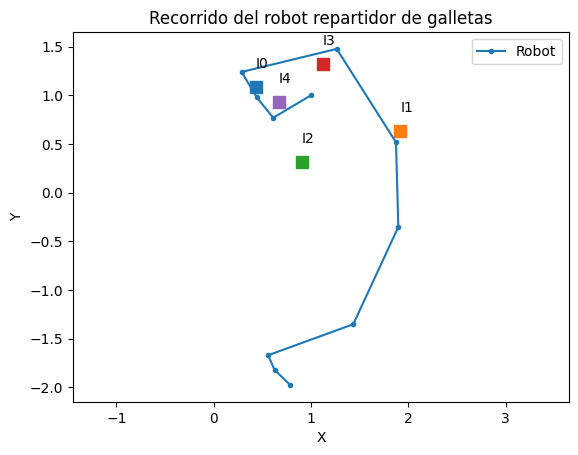

In [52]:
# robot_pg_notebook.py

import random, math, copy
import matplotlib.pyplot as plt

# ————— Parámetros del problema —————
N         = 5          # Nº de ingenieros
ROOM_SIZE = 2       # Sala cuadrada [0,ROOM_SIZE]^2
T_MAX     = 10         # Pasos de simulación
GENERATIONS = 30       # <-- Cambia aquí el nº de generaciones

# Posiciones fijas de los ingenieros
engineers_pos = [(random.uniform(0, ROOM_SIZE),
                  random.uniform(0, ROOM_SIZE)) for _ in range(N)]

# Sensores globales que usan los terminales
distances = [1] * N
angles    = [1] * N

# ————— Funciones protegidas —————
def pdiv(x, y):      return x / y if y != 0 else 1.0
def safe_sin(x):     return math.sin(x) if -1e6<x<1e6 else 0.0
def safe_cos(x):     return math.cos(x) if -1e6<x<1e6 else 0.0

# ————— Clases GP —————
class Terminal:
    def __init__(self, name, func): self.name, self.func = name, func
    def eval(self): return self.func()
    def __str__(self): return self.name

class Primitive:
    def __init__(self, name, arity, func): self.name, self.arity, self.func = name, arity, func
    def __str__(self): return self.name

class Node:
    def __init__(self, content, children=None):
        self.content, self.children = content, children or []
    def eval(self):
        if isinstance(self.content, Terminal):
            return self.content.eval()
        args = [ch.eval() for ch in self.children]
        return self.content.func(*args)
    def __str__(self):
        if isinstance(self.content, Terminal):
            return str(self.content)
        return f"{self.content.name}(" + ", ".join(str(c) for c in self.children) + ")"

# ————— Primitivas y terminales —————
primitives = [
    Primitive("add", 2, lambda x,y: x+y),
    Primitive("sub", 2, lambda x,y: x-y),
    Primitive("mul", 2, lambda x,y: x*y),
    Primitive("pdiv",2, pdiv),
    Primitive("sin", 1, safe_sin),
    Primitive("cos", 1, safe_cos),
    Primitive("if>", 3, lambda c,a,b: a if c>0 else b),
]

terminal_gens = []
for i in range(N):
    terminal_gens += [
        (lambda i=i: Terminal(f"d{i}",     lambda i=i: distances[i])),
        (lambda i=i: Terminal(f"theta{i}", lambda i=i: angles[i]))
    ]
terminal_gens.append(
    lambda: Terminal(f"const({random.uniform(-1,1):.2f})",
                     lambda val=random.uniform(-1,1): val)
)

def generate_tree(max_depth, grow_p=0.7):
    if max_depth==0 or random.random()>grow_p:
        return Node(random.choice(terminal_gens)())
    prim = random.choice(primitives)
    return Node(prim, [generate_tree(max_depth-1,grow_p) for _ in range(prim.arity)])

def get_all_nodes(root):
    out=[]
    def rec(node,p,i):
        out.append((node,p,i))
        for idx,ch in enumerate(node.children):
            rec(ch,node,idx)
    rec(root,None,None)
    return out

def subtree_crossover(a,b):
    ac, bc = copy.deepcopy(a), copy.deepcopy(b)
    n1, n2 = get_all_nodes(ac), get_all_nodes(bc)
    nA,pA,iA = random.choice(n1); nB,pB,iB = random.choice(n2)
    if pA: pA.children[iA]=nB
    else:   ac = nB
    if pB: pB.children[iB]=nA
    else:   bc = nA
    return ac, bc

def subtree_mutation(tree, max_d):
    tc = copy.deepcopy(tree)
    nodes = get_all_nodes(tc)
    n,p,i = random.choice(nodes)
    new_sub = generate_tree(max_d)
    if p: p.children[i] = new_sub
    else: tc = new_sub
    return tc

# ————— Función de aptitud con penalizaciones —————
def evaluate(ind, λ_miss=2.0, λ_dist=0.05):
    dx, dy = ind
    x,y = ROOM_SIZE/2, ROOM_SIZE/2
    delivered = [False]*N
    score = 0
    total_d = 0.0
    for _ in range(T_MAX):
        for i,(ex,ey) in enumerate(engineers_pos):
            distances[i] = math.hypot(ex-x,ey-y)
            angles[i]    = math.atan2(ey-y,ex-x)
        mvx, mvy = dx.eval(), dy.eval()
        total_d += math.hypot(mvx,mvy)
        x,y = x+mvx, y+mvy
        for i,(ex,ey) in enumerate(engineers_pos):
            if not delivered[i] and abs(x-ex)<0.2 and abs(y-ey)<0.2:
                delivered[i]=True; score+=1
    misses = N-score
    return score - λ_miss*misses - λ_dist*total_d

def tournament_selection(pop,fits,k=3):
    return max(random.sample(list(zip(pop,fits)),k), key=lambda t: t[1])[0]

def genetic_programming(pop_size=30, gens=20, cx_p=0.5, mut_p=0.2, tour_k=3, max_d=4):
    pop = [(generate_tree(max_d), generate_tree(max_d)) for _ in range(pop_size)]
    fits = [evaluate(ind) for ind in pop]
    for g in range(gens):
        newpop=[]
        while len(newpop)<pop_size:
            p1 = tournament_selection(pop,fits,tour_k)
            if random.random()<cx_p:
                p2 = tournament_selection(pop,fits,tour_k)
                c1x,c2x = subtree_crossover(p1[0],p2[0])
                c1y,c2y = subtree_crossover(p1[1],p2[1])
                offs = [(c1x,c1y),(c2x,c2y)]
            else:
                offs = [(copy.deepcopy(p1[0]),copy.deepcopy(p1[1]))]
            for off in offs:
                if len(newpop)>=pop_size: break
                if random.random()<mut_p:
                    off = (subtree_mutation(off[0],max_d),
                           subtree_mutation(off[1],max_d))
                newpop.append(off)
        pop, fits = newpop, [evaluate(ind) for ind in newpop]
        print(f"Gen {g+1}/{gens} – best fitness = {max(fits):.2f}")
    idx = fits.index(max(fits))
    return pop[idx], fits[idx]

# ————— Ejecutar y visualizar —————
best, best_fit = genetic_programming(gens=GENERATIONS)
print("\nMejor fitness:", best_fit)

# extraer árboles
dx_tree, dy_tree = best

# simular trayectoria
x,y = ROOM_SIZE/2, ROOM_SIZE/2
path_x, path_y = [x],[y]
for _ in range(T_MAX):
    for i,(ex,ey) in enumerate(engineers_pos):
        distances[i] = math.hypot(ex-x,ey-y)
        angles[i]    = math.atan2(ey-y,ex-x)
    x += dx_tree.eval(); y += dy_tree.eval()
    path_x.append(x); path_y.append(y)

# plot
plt.figure()
plt.plot(path_x,path_y, marker='.', label='Robot')
for i,(ex,ey) in enumerate(engineers_pos):
    plt.scatter(ex,ey, s=80, marker='s')
    plt.text(ex,ey+0.2,f"I{i}")
plt.title("Recorrido del robot repartidor de galletas")
plt.xlabel("X"); plt.ylabel("Y")
plt.axis("equal"); plt.legend()
plt.show()


La trayectoria muestra un desplazamiento inicial innecesario hacia el sur, seguido de dos bloques eficientes de entregas (I1→I3 y luego I4→I0), pero aún así omite al ingeniero I2 y suma distancia extra; conviene por tanto reforzar la penalización por omitir destinatarios y ajustar el peso de la distancia para forzar rutas más directas y asegurar la cobertura completa.